# Asset Allocation with Pytorch

 Goal of this notebook is to create a model to combine the signals from the various strategies to create an asset allocation neural network to outperform equally weighted, as Markowitz may not be appropriate as the signals may be to buy or sell the same asset therefore yielding a perfect correlation when active.

In [1]:
from loguru import logger
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
from tqdm import tqdm
import typing as t


In [2]:
from quantified_strategies import utils

In [3]:
CASH = "CASH"

In [4]:
ASSETS = ["SPY", CASH]
ASSETS = ["SPY"]
ASSETS

['SPY']

## Dataset Collection

In [5]:
def get_data(assets: str | t.List[str], is_classification: bool = True) -> t.Tuple[pd.DataFrame, pd.DataFrame]:

    def get_y() -> pd.DataFrame:
        price_data = [utils.get_data(ticker=ticker, columns="Adj Close").to_frame(name=ticker) for ticker in assets if ticker != "CASH"]
        price_data = pd.concat(price_data, axis=1)
        return_data = price_data.pct_change()
        if "CASH" in assets:
            return_data["CASH"] = 0.0
        return_data = return_data.shift(-1)
        return_data = return_data.dropna()

        if is_classification:
            return (return_data > 0).astype(int)
        
        return return_data

    def get_X() -> pd.DataFrame:
        strategy_returns = pd.read_csv(f"outputs/strategy_returns.csv", index_col=0, header=[0, 1, 2])
        strategy_returns = strategy_returns.loc[:, strategy_returns.columns.get_level_values(2).isin(assets)]
        strategy_returns.index = pd.DatetimeIndex(strategy_returns.index)
        is_active = ~(strategy_returns.isna())
        is_active = is_active.astype(int)
        return is_active

    assets = assets if isinstance(assets, list) else [assets]

    # Get target variables: these are the returns from entering a position from close to close t+1
    y = get_y()
    
    # Get explanatory variables: these are the signals from the strategies indicating whether to buy or not
    X = get_X()

    ret_t_minus_1 = y.rename(columns={col: f"{col}_ret_t_minus_1" for col in y.columns})
    ret_t_minus_1 = ret_t_minus_1.shift(1).fillna(0.0)
    X = pd.concat([X, ret_t_minus_1], axis=1)
    X = X.dropna()

    X = X.loc[X.index.isin(X.index.intersection(y.index))]
    y = y.loc[y.index.isin(y.index.intersection(X.index))]

    X = X.sort_index()
    y = y.sort_index()

    return X, y

orig_X_total, orig_y_total = get_data(assets=ASSETS, is_classification=False)

In [6]:
print(f"{orig_X_total.shape = }")
print(f"{orig_y_total.shape = }")

orig_X_total.shape = (6072, 9)
orig_y_total.shape = (6072, 1)


In [7]:
orig_X_total.head(1)

,"(event_trading, super_bowl, SPY)","(overnight_trading, short_term_reversal, SPY)","(seasonal_trading, buy_when_yields_are_low, SPY)","(seasonal_trading, pay_day_strategy, SPY)","(seasonal_trading, santa_claus_strategy, SPY)","(seasonal_trading, september_bear, SPY)","(seasonal_trading, tax_day_strategy, SPY)","(seasonal_trading, turn_around_tuesday_strategy, SPY)",SPY_ret_t_minus_1
Date,,,,,,,,,
2000-01-03,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.009788


In [8]:
orig_y_total.head(1)

,SPY
Date,
2000-01-03,-0.039106


In [9]:
assert orig_X_total.dropna().shape[0] == orig_X_total.shape[0]
assert orig_y_total.dropna().shape[0] == orig_y_total.shape[0]

In [10]:
orig_y_total

,SPY
Date,
2000-01-03,-0.039106
2000-01-04,0.001788
2000-01-05,-0.016071
2000-01-06,0.058076
2000-01-07,0.003430
...,...
2024-02-14,0.006900
2024-02-15,-0.004980
2024-02-16,-0.005505


## Create Pytorch Model

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

### Define `device` to use when training model

In [12]:
def get_device() -> torch.device:

    if torch.cuda.is_available():
        logger.info("Running on the GPU")
        n_gpu = 0 # different if you have more than 1
        assert n_gpu <= (torch.cuda.device_count() - 1)
        logger.info(f"Using gpu={n_gpu} out of {torch.cuda.device_count()}")
        device = torch.device(f"cuda:{n_gpu}")
    else:
        logger.info("Running on the CPU")
        device = torch.device("cpu")
    
    return device

DEVICE = get_device()
DEVICE

2024-02-23 13:45:16.500 | INFO     | __main__:get_device:10 - Running on the CPU


device(type='cpu')

In [14]:

class Net(nn.Module):

    # Model Type: used to save model
    MODEL_TYPE: str = "rnn"

    # Sequences to use when creating prediction
    DEFAULT_SEQUENCE_LENGTH: int = 5
    # Step size to use when creating sequence
    DEFAULT_STEP_SIZE: int = 1
    
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        self.input_shape: int = input_shape
        self.output_shape: int = output_shape
        
        self.hidden_layers = 3
        self.hidden_size = 10
        
        self.rnn = nn.RNN(
            input_size=self.input_shape, 
            hidden_size=self.hidden_size, 
            num_layers=self.hidden_layers, 
            batch_first=False,
        )
        
        self.fc1 = nn.Linear(self.hidden_size, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, self.output_shape)

    def forward(self, x):

        # Assuming x is (batch_size x seq_len x input_size)
        assert x.size(2) == self.input_shape, f"""Provided `x` is not of shape 
            batch_size x seq_len x input_size: expected ? x ? x {self.input_shape} but received {x.shape}"""
        seq_len = x.size(1)
        
        # Set initial hidden state: (hidden layers x sequence length x hidden size)
        h0 = torch.zeros(self.hidden_layers, seq_len, self.hidden_size)
        
        # Pass in x (sequence of values) and the initial hidden state (all zeros)
        # Do not need hidden output so discard
        x, _ = self.rnn(x, h0)
        
        # Output will be of shape batch_size x seq_len x hidden_size so get the last value in the sequence
        x = x[:, -1, :]

        # Apply layers after RNN
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        assert x.shape[-1] == self.output_shape

        # Define Position in each asset
        # output = F.tanh(x)
        output = F.sigmoid(x)
        # output = F.softmax(x, dim=1)
        # output = F.tanh(x)
        # output = torch.div(output.T, torch.sum(output, dim=1)).T
        
        return output

    @staticmethod
    def translate(X: torch.Tensor, y: torch.Tensor, sequence_length: int = DEFAULT_SEQUENCE_LENGTH, step_size: int = DEFAULT_STEP_SIZE,
                 ) -> t.Tuple[torch.Tensor, torch.Tensor]:
        
        num_samples: int = X.shape[0]
        num_variables: int = X.shape[1]
        
        # Create a new dataset with overlapping sequences
        new_X = []
        new_y = []
        for i in range(sequence_length, num_samples, step_size):
            # Fetch last `sequence_length` of X
            new_X.append(X[(i - sequence_length):i])
            # Fetch i-th value of y
            new_y.append(y[i])
    
        # Convert lists to tensors
        new_X = torch.stack(new_X)
        new_y = torch.stack(new_y)
            
        return new_X, new_y


def example():

    # Define input and output sizes for neural network
    INPUT_SHAPE = 10
    OUTPUT_SHAPE = 2
    print(f"Input Shape = {INPUT_SHAPE}, Output Shape = {OUTPUT_SHAPE}")

    
    # Generate example data
    N_SAMPLES = 10
    X_sample = torch.randn(N_SAMPLES, INPUT_SHAPE)
    y_sample = torch.randn(N_SAMPLES, 1)
    print(f"{X_sample.shape = }, {y_sample.shape = }")
    
    X_sample_translated, y_sample_translated = Net.translate(X=X_sample, y=y_sample, sequence_length=4, step_size=1)
    print(f"{X_sample_translated.shape = }, {y_sample_translated.shape = }")

    X_sample_translated = X_sample_translated.to(device=DEVICE)
    y_sample_translated = y_sample_translated.to(device=DEVICE)

    # Initiate Network
    my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE).to(device=DEVICE)
    output = my_net.forward(x=X_sample_translated)
    print(f"{output.shape = }")
    print(f"{output = }")
    
    return

example()

Input Shape = 10, Output Shape = 2
X_sample.shape = torch.Size([10, 10]), y_sample.shape = torch.Size([10, 1])
X_sample_translated.shape = torch.Size([6, 4, 10]), y_sample_translated.shape = torch.Size([6, 1])
output.shape = torch.Size([6, 2])
output = tensor([[0.6830, 0.3825],
        [0.6940, 0.3872],
        [0.6991, 0.3921],
        [0.6903, 0.3831],
        [0.6927, 0.3833],
        [0.6895, 0.3904]], grad_fn=<SigmoidBackward0>)


In [15]:
my_net = Net(input_shape=10, output_shape=2).to(device=DEVICE)
my_net

Net(
  (rnn): RNN(10, 10, num_layers=3)
  (fc1): Linear(in_features=10, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)

### Translate Data to Correct Format

In [724]:
SHUFFLE = False

def convert_data_to_tensors(X: pd.DataFrame, y: pd.DataFrame) -> t.Tuple[torch.Tensor, torch.Tensor]:    
    X_tensor = torch.Tensor(X.values) if isinstance(X, pd.DataFrame) else X
    y_tensor = torch.Tensor(y.values) if isinstance(y, pd.DataFrame) else y
    return X_tensor, y_tensor

def split_data(X: torch.Tensor, y: torch.Tensor) -> t.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    return train_test_split(X, y, train_size=0.7, shuffle=SHUFFLE)


In [725]:
X_total, y_total = convert_data_to_tensors(X=orig_X_total, y=orig_y_total)
X_total, y_total = Net.translate(X=X_total, y=y_total)
X_train, X_test, y_train, y_test = split_data(X=X_total, y=y_total)
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

X_train.shape = torch.Size([4246, 5, 9])
y_train.shape = torch.Size([4246, 1])
X_test.shape = torch.Size([1821, 5, 9])
y_test.shape = torch.Size([1821, 1])


## Model Callbacks

In [726]:
class EarlyStopping:
    DEFAULT_PATIENCE: int = 5
    DEFAULT_MIN_DELTA: int = 0
    
    def __init__(self, patience: int = DEFAULT_PATIENCE, min_delta: int = DEFAULT_MIN_DELTA, 
                 maximize: bool = False, min_periods: int = 0):

        self.patience: int = patience
        self.min_delta: int = min_delta
        self.maximize: bool = maximize
        self.min_periods: int = min_periods

        # Benchmark Loss
        self.best_loss: float = -np.inf if maximize else np.inf

        # Number of Updates - used for min periods before applying early stopping
        self.updates: int = 0
        # Counter to count updates since last minimum
        self.counter: int = 0
        # Boolean to indicate whether to stop or continue training
        self.early_stop: bool = False

    def __call__(self, loss: float) -> None:

        """ Updates state and sets `early_stop` to True when the loss has not improved by `min_loss` in `patience` updates. """

        self.updates += 1

        if (((loss + self.min_delta) < self.best_loss) and not self.maximize) or (((loss - self.min_delta) > self.best_loss) and self.maximize):
            self.best_loss = loss
            self.counter = 0
            return

        if (((loss + self.min_delta) > self.best_loss) and not self.maximize) or (((loss - self.min_delta) < self.best_loss) and self.maximize):
            self.counter += 1
            if (self.counter >= self.patience) and (self.updates > self.min_periods):
                self.early_stop = True
        
        return


### Global Model Training Parameters

In [838]:
def my_loss(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

    if output.shape[-1] != target.shape[-1]:
        output = output.reshape(target.shape[0], target.shape[1])
    
    port_return = output * target
    try:
        port_return = torch.sum(port_return, dim=1)
    except IndexError:
        pass
    
    mean_return = torch.mean(port_return)
    std_return = torch.std(port_return)
    
    sharpe = mean_return / (std_return + 1e-10)

    num = torch.sum(torch.abs(output))
    denom = output.shape[0]
    multiplier = torch.sqrt(252 * num / denom)
    
    ann_sharpe = multiplier * sharpe
    
    return ann_sharpe


loss_function = nn.CrossEntropyLoss()
loss_function = nn.MSELoss()
loss_function = my_loss

MAXIMIZE_LOSS = True

BATCH_SIZE = 64
EPOCHS = 100
TEST_BATCH_SIZE = 128
LEARNING_RATE = 0.01

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.0
EARLY_STOPPING_MIN_PERIODS = 50

assert BATCH_SIZE <= X_train.shape[0]
assert TEST_BATCH_SIZE <= X_test.shape[0]

### Model Training Functions

In [839]:

def get_prediction(net: Net, X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    X = X.to(device=DEVICE)
    y = y.to(device=DEVICE)

    outputs = net(X)
    
    return outputs


def fwd_pass(net: Net, X: torch.Tensor, y: torch.Tensor, optimizer: torch.optim = None, do_train: bool = False):

    acc = 0.15
    
    X = X.to(device=DEVICE)
    y = y.to(device=DEVICE)

    filtr = [(torch.sum(X[i, -1, :-y.shape[-1]]) != 0) for i in range(X.shape[0])]
    # X, y = X[filtr], y[filtr]

    if X.shape[0] < 1:
        return 0, 0
    
    if do_train:
        net.zero_grad()

    outputs = net(X)
    
    matches = [int(i > 0) == int(j > 0) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    
    loss = loss_function(outputs, y)

    if do_train:
        assert optimizer is not None, f"Optimizer not provided in fwd_pass with training"
        loss.backward()
        optimizer.step()
    
    return acc, loss


def train(net: Net, store: bool = False):

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, maximize=MAXIMIZE_LOSS)
    early_stopping = EarlyStopping(
        patience=EARLY_STOPPING_PATIENCE, 
        min_delta=EARLY_STOPPING_MIN_DELTA, 
        maximize=MAXIMIZE_LOSS,
        min_periods=EARLY_STOPPING_MIN_PERIODS,
    )
    
    MODEL_NAME: str = f"{net.MODEL_TYPE}-model-{int(time.time())}"
    
    logger.info(f"Training: {MODEL_NAME!r}")

    with open(f"outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log", "a") as log:
        
        for epoch in range(EPOCHS):
            
            for i in tqdm(range(0, len(X_train), BATCH_SIZE)):

                batch_X = X_train[i:(i + BATCH_SIZE)].to(device=DEVICE)
                batch_y = y_train[i:(i + BATCH_SIZE)].to(device=DEVICE)

                acc, loss = fwd_pass(net=net, X=batch_X, y=batch_y, optimizer=optimizer, do_train=True)
            
            # val_acc, val_loss = test(net=net, size=TEST_BATCH_SIZE)
            acc, loss = evaluate(net=net, X=X_train, y=y_train)
            val_acc, val_loss = evaluate(net=net, X=X_test, y=y_test)
            if store:
                log.write(f"{MODEL_NAME},{time.time():.3f},{epoch},{acc:.4f},{loss:.4f},{val_acc:.4f},{val_loss:.4f}\n")
            logger.info(f"Epoch: {epoch} / {EPOCHS}, Loss: {loss}, Val Loss: {val_loss}, Accuracy: {acc}, Val Accuracy: {val_acc}")

            # early stopping
            early_stopping(loss)
            if early_stopping.early_stop:
                val_acc, val_loss = test(net=net, size=None)
                logger.info(f"Early Stopping reached @ {epoch = }! Best Loss: {early_stopping.best_loss}, Loss: {loss}," +\
                            f"Val Loss: {val_loss}, Accuracy: {acc}, Val Accuracy: {val_acc}")
                break

    if store:
        torch.save(net.state_dict(), f"outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}-state.dict")
        shutil.copy(f"outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log", f"outputs/models/{net.MODEL_TYPE}-model-latest.log")
        shutil.copy(f"outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}-state.dict", f"outputs/models/{net.MODEL_TYPE}-model-latest-state.dict")
    else:
        os.remove(f"outputs/models/{net.MODEL_TYPE}-model-{MODEL_NAME}.log")

    return
    

def test(net: Net, size: int = None) -> t.Tuple[float, torch.Tensor]:

    if size is None:
        X, y = X_test, y_test
    else:
        # Get random split of test data of size `size`
        random_start = np.random.randint(X_test.shape[0] - size)
        X, y = X_test[random_start:(random_start + size)], y_test[random_start:(random_start + size)]

    filtr = [(torch.sum(X[i, -1, :-1]) != 0) for i in range(X.shape[0])]
    X, y = X[filtr], y[filtr]
    
    return evaluate(net=net, X=X, y=y)


def evaluate(net: Net, X: torch.Tensor, y: torch.Tensor) -> t.Tuple[float, torch.Tensor]:

    with torch.no_grad():
        acc, loss = fwd_pass(net=net, X=X, y=y, do_train=False)

    return acc, loss
    

## Model Training

In [840]:
INPUT_SHAPE = X_train.shape[-1]
OUTPUT_SHAPE = y_train.shape[-1]

print(f"Input Shape: {INPUT_SHAPE}, Output Shape: {OUTPUT_SHAPE}")

Input Shape: 9, Output Shape: 1


In [841]:
my_net = Net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE).to(device=DEVICE)
train(net=my_net, store=True)

2024-02-22 21:37:38.400 | INFO     | __main__:train:53 - Training: 'rnn-model-1708637858'
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 41.54it/s]
2024-02-22 21:37:40.752 | INFO     | __main__:train:71 - Epoch: 0 / 1000, Loss: 0.3080836832523346, Val Loss: 0.7783706188201904, Accuracy: 0.5390956194065002, Val Accuracy: 0.5502471169686985
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 41.71it/s]
2024-02-22 21:37:43.202 | INFO     | __main__:train:71 - Epoch: 1 / 1000, Loss: 0.31330785155296326, Val Loss: 0.7931838631629944, Accuracy: 0.5390956194065002, Val Accuracy: 0.5502471169686985
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 42.36it/s]
2024-02-22 21:37:45.651 | INFO     | __main__:train:71 - Epoch: 2 / 1000, Loss: 0.3143881559371948, Val Loss: 0.7961813807487488, Accuracy: 0.5390956194065002, Val

In [842]:
acc, loss = test(net=my_net)
print(f"{acc = :.2%}, {loss = :.5f}")

acc = 55.61%, loss = 0.94382


## Plot Loss

In [806]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

%matplotlib inline

In [807]:

def create_acc_loss_graph(model_name: str):

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    color_map = {"train": colors[0], "test": colors[1]}
    
    contents = pd.read_csv(f"outputs/models/{model_name}.log", names=["name", "time", "epoch", "acc", "loss", "val_acc", "val_loss"])

    fig = plt.figure(figsize=(15, 7))

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(contents["epoch"], contents["acc"], label="acc", color=color_map["train"])
    twinx1 = ax1#.twinx()
    twinx1.plot(contents["epoch"], contents["val_acc"], label="val_acc", color=color_map["test"])
    ax1.legend(loc=2)

    ax2.plot(contents["epoch"], contents["loss"], label="loss", color=color_map["train"])
    # ax2.set_yscale("log")
    ax2.legend(loc=2)
    twinx2 = ax2#.twinx()
    twinx2.plot(contents["epoch"], contents["val_loss"], label="val_loss", color=color_map["test"])
    # twinx2.set_yscale("log")
    twinx2.legend(loc=1)

    n = contents.shape[0] // 8
    ax1.set_xticklabels(contents["epoch"].tolist()[::n])
    ax1.set_xticks([*range(0, contents.shape[0], n)])

    plt.show()

    return


C:\Users\tomw1\AppData\Local\Temp\ipykernel_27160\944549769.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(contents["epoch"].tolist()[::n])


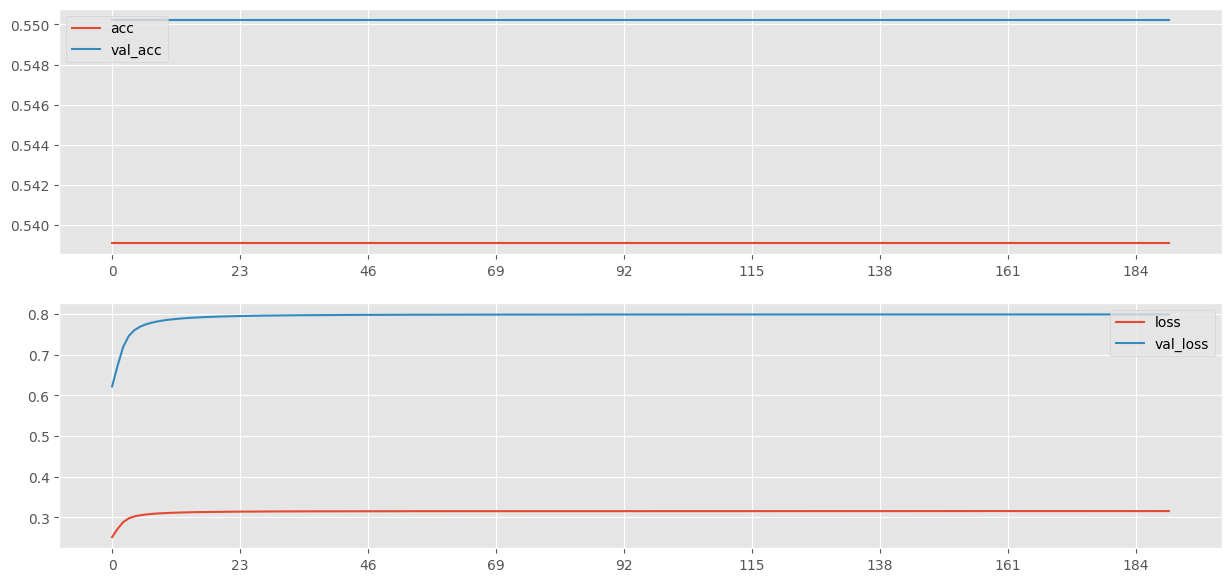

In [837]:
MODEL_NAME = f"{Net.MODEL_TYPE}-model-latest"
create_acc_loss_graph(model_name=MODEL_NAME)

In [809]:
filtr_train = [(torch.sum(X_train[i, -1, :-orig_y_total.shape[1]]) != 0) for i in range(X_train.shape[0])]

In [810]:
y_train_hat = get_prediction(net=my_net, X=X_train, y=y_train)

In [811]:
my_loss(output=y_train_hat[filtr_train], target=y_train[filtr_train])

tensor(0.3841, grad_fn=<MulBackward0>)

In [812]:
my_loss(output=y_train_hat, target=y_train)

tensor(0.3156, grad_fn=<MulBackward0>)

In [813]:
filtr_test = [(torch.sum(X_test[i, -1, :-orig_y_total.shape[1]]) != 0) for i in range(X_test.shape[0])]

In [814]:
y_test_hat = get_prediction(net=my_net, X=X_test, y=y_test)

In [815]:
my_loss(output=y_test_hat[filtr_test], target=y_test[filtr_test])

tensor(0.9438, grad_fn=<MulBackward0>)

In [816]:
my_loss(output=y_test_hat, target=y_test)

tensor(0.7995, grad_fn=<MulBackward0>)

In [817]:
X_df = pd.DataFrame([X_test[i][-1].detach().numpy() for i in range(X_test.shape[0]) if filtr_test[i]], columns=[col[1] for col in orig_X_total.columns])
df = pd.concat([
    pd.DataFrame([y_test[i].detach().numpy() for i in range(X_test.shape[0]) if filtr_test[i]], columns=orig_y_total.columns),
    pd.DataFrame([y_test_hat[i].detach().numpy() for i in range(X_test.shape[0]) if filtr_test[i]], columns=[f"{col}_pos" for col in orig_y_total.columns]),
    X_df,
], axis=1)

In [818]:
(df.loc[df["september_bear"] == 1.0, "SPY"] > 0).mean()

0.45714285714285713

In [819]:
(df.loc[df["september_bear"] != 1.0, "SPY"] > 0).mean()

0.5585143658023827